BERT Classification Model using TFHUB; Stratified sampling

### Imports

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 372251701872441568
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16683734046773967157
physical_device_desc: "device: XLA_CPU device"
]


In [6]:
!pip install bert_for_tf2

     |████████████████████████████████| 40kB 2.1MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=fa4e003c40009338f9f56d0de26af6a26a3e2ae760b226dc69816fe58bc0b0a8
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=941da0a92eb886ecbbf673dcec3292a73b24a0e21c5670e7a685d6ebdca249c6
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=ca4f831ed91b66e9686dbacd598d826ceb81569bbe93da24e927b7821f645cf2
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [7]:
!pip install transformers

     |████████████████████████████████| 573kB 3.4MB/s 
     |████████████████████████████████| 1.0MB 54.8MB/s 
     |████████████████████████████████| 890kB 50.2MB/s 
     |████████████████████████████████| 3.7MB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=c99bf8ab8fd346fc1215be4c5c44cb36a701cc8a4d0f8b215a8a82a027605332
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [8]:
!pip install scikit-plot

In [9]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import unicodedata
import re

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sn
import scikitplot as skplt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
pd.set_option('display.max_colwidth', 500)
tf.__version__

'2.2.0-rc3'

In [0]:
# BERT_URL = 'https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1'
# module = hub.load(BERT_URL)

### Import BERT TFHub model and create a tokenizer

In [0]:
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'

In [0]:
bert_layer = hub.KerasLayer(bert_path)

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [0]:
bert_tokenizer_tfhub = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case=True)

### Helper Functions & Methods to transform input to BERT compatable form. 
Input values are tokenizer and the dataframe with two columns (sentence pairs). Out is the tensors for tokens, masks and segments (as required by Bert)

In [0]:
## Below section is compatible with TF HUB
def _get_segments(sentences):
    sentences_segments = []
    for sent in sentences:
      temp = []
      i = 0
      for token in sent.split(" "):
        temp.append(i)
        if token == "[SEP]":
          i += 1
      sentences_segments.append(temp)
    return sentences_segments

def _get_inputs(df,_maxlen,tokenizer,use_keras_pad=False, verbose=0):

    maxqnans = np.int((_maxlen-20)/2)
    # pattern = '[^\w\s]+|\n' # remove everything including newline (|\n) other than words (\w) or spaces (\s)
    pattern = '\n' # remove everything including newline (|\n) other than words (\w) or spaces (\s)
    
    sentences = ["[CLS] " + " ".join(tokenizer.tokenize(txt)) +" [SEP] " 
              + " ".join(tokenizer.tokenize(head)) +" [SEP]" 
                for (txt,head) 
                in 
              zip(df['Text'].str.replace(pattern, '').values.tolist(),
              df['News headline'].str.replace(pattern, '').values.tolist())]
   
    # print(sentences)
    if (verbose > 0):
      for i in range(min(len(sentences),3)):
        print(sentences[i])
      
    #generate masks
    # bert requires a mask for the words which are padded. 
    # Say for example, maxlen is 100, sentence size is 90. then, [1]*90 + [0]*[100-90]
    sentences_mask = [[1]*len(sent.split(" "))+[0]*(_maxlen - len(sent.split(" "))) for sent in sentences]
 
    #generate input ids  
    # if less than max length provided then the words are padded
    if use_keras_pad:
      sentences_padded = pad_sequences(sentences.split(" "), dtype=object, maxlen=10, value='[PAD]',padding='post')
    else:
      sentences_padded = [sent + " [PAD]"*(_maxlen-len(sent.split(" "))) if len(sent.split(" "))!=_maxlen else sent for sent in sentences ]

    sentences_converted = [tokenizer.convert_tokens_to_ids(s.split(" ")) for s in sentences_padded]
    
    #generate segments
    # for each separation [SEP], a new segment is converted
    sentences_segment = _get_segments(sentences_padded)

    genLength = set([len(sent.split(" ")) for sent in sentences_padded])

    if _maxlen < 20:
      raise Exception("max length cannot be less than 20")
    elif len(genLength)!=1: 
      print(genLength)
      raise Exception("sentences are not of same size")

    # return [tf.cast(sentences_converted,tf.int32), tf.cast(sentences_segment,tf.int32), tf.cast(sentences_mask,tf.int32)]
    return [tf.cast(sentences_converted,tf.int32), tf.cast(sentences_mask,tf.int32), tf.cast(sentences_segment,tf.int32)]

In [0]:
def return_labels(np_arr):
  return [dict_cat[idx] for idx in list(np_arr)]

def prediction_labels(mdl, np_arr):
  argmax_output = [np.argmax(lst) for lst in list(mdl.predict(np_arr))]
  return return_labels(argmax_output)

def label(x):
  return dict_cat[x]

In [0]:
def preprocess(s):
  # for details, see https://www.tensorflow.org/alpha/tutorials/sequences/nmt_with_attention
  s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
  # s = re.sub(r"([?.!,¿])", r" \1 ", s)
  s = re.sub(r'(https?://[www\.]?\w*\.[\w/$]*)', '', s) # remove URLs
  s = re.sub(r'[" "]+', " ", s)
  s = re.sub(r"[^a-zA-Z?.!,¿]+", " ", s) # remove numbers
  s = s.strip()
  return s

In [0]:
def gen_combined_results(X, mdl, Xtst, y):
  true_label = return_labels(y)
  pred_target = [np.argmax(lst) for lst in list(mdl.predict(Xtst))]
  pred_label = return_labels(pred_target)

  comb_results = pd.DataFrame()
  comb_results['Text'] = X['Text']
  comb_results['News headline'] = X['News headline']
  comb_results['Label'] = X['Label']
  comb_results['true_Label'] = true_label
  comb_results['target'] = list(y)
  comb_results['pred_target'] = pred_target
  comb_results['pred_Label'] = pred_label

  return comb_results

In [0]:
def plot_results(true, pred, sample_weight=None, normalize=None, classes=None, ax=None):
  cm = confusion_matrix(true, pred, sample_weight=sample_weight,
                          labels=classes, normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
  return disp.plot(include_values=True, 
                     cmap='plasma', ax=ax, xticks_rotation='vertical',
                     values_format=None)

In [0]:
def label_transform(l):
  if (l == 'COMMENT'):
    ret = l
  else:
    ret = 'OTHER'
  
  return ret

In [22]:
## This is the tokenizer using transformers. Not used in this notebook. 

from transformers import (TFBertForSequenceClassification, 
                          BertTokenizer,
                          TFRobertaForSequenceClassification, 
                          RobertaTokenizer)

bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-cased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def convert_to_features(
    examples,
    tokenizer,
    max_length=512,
    task=None,
    label_list=None,
    output_mode=None,
    pad_on_left=False,
    pad_token=0,
    pad_token_segment_id=0,
    mask_padding_with_zero=True,
):
   

    features = []
    tokens = []
    masks = []
    segments = []

    for idx,example in examples.iterrows():

        inputs = tokenizer.encode_plus(
            example['Text'], example['News headline'], add_special_tokens=True, max_length=max_length, return_token_type_ids=True,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
        assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(
            len(attention_mask), max_length
        )
        assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(
            len(token_type_ids), max_length
        )
        
        tokens.append(input_ids)
        masks.append(attention_mask)
        segments.append(token_type_ids)

        if idx < 3:
            print("*** Example ***")
            print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            print("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            print("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))

    return [tf.cast(tokens,tf.int32), tf.cast(masks,tf.int32), tf.cast(segments,tf.int32)]


In [23]:
re.sub(r"[^a-zA-Z?.!,¿]+", '', 'text 1, 2, 3...')
# re.sub(r"([?.!,¿])", r" \1 ", 'text 1, 2, 3...')
# re.sub(r"[^\w\s]+|\n", 'X', 'text 1, 2, 3...')

'text,,...'

### Test method for checking inputs to Bert layer

In [0]:
df_t = pd.DataFrame(columns=['Text', 'News headline'])
df_t['Text'] = ['It''s a 45 person, lady? https://ts.dcosl',' It''s the second sentence for testing']
df_t['News headline'] = ['The Senate is voting on 23654 a 20-week abortion ban. Opponents say it''s ‚Äúbasically relying on junk science.‚Äù',' Iam the 2nd sentence. And then again the next'] 

In [0]:
df_t

,Text,News headline
0,"Its a 45 person, lady? https://ts.dcosl",The Senate is voting on 23654 a 20-week abortion ban. Opponents say its ‚Äúbasically relying on junk science.‚Äù
1,Its the second sentence for testing,Iam the 2nd sentence. And then again the next


In [0]:
df_t['Text'].astype(str).apply(preprocess)

0                    Its a person, lady?
1    Its the second sentence for testing
Name: Text, dtype: object

In [0]:
df_t['Text'] = df_t['Text'].astype(str).apply(preprocess)
df_t['News headline'] = df_t['News headline'].astype(str).apply(preprocess)

In [0]:
df_t

,Text,News headline
0,"Its a person, lady?",The Senate is voting on a week abortion ban. Opponents say its Aubasically relying on junk science. Au
1,Its the second sentence for testing,Iam the nd sentence. And then again the next


In [0]:
# ft = convert_to_features(df_t,bert_tokenizer,50)

In [0]:
bert_inputs = _get_inputs(df_t,tokenizer=bert_tokenizer_tfhub,_maxlen=50, verbose=1)

[CLS] its a person , lady ? [SEP] the senate is voting on a week abortion ban . opponents say its au ##bas ##ically relying on junk science . au [SEP]
[CLS] its the second sentence for testing [SEP] ia ##m the n ##d sentence . and then again the next [SEP]


In [0]:
bert_inputs

[<tf.Tensor: shape=(2, 50), dtype=int32, numpy=
 array([[  101,  2049,  1037,  2711,  1010,  3203,  1029,   102,  1996,
          4001,  2003,  6830,  2006,  1037,  2733, 11324,  7221,  1012,
          7892,  2360,  2049,  8740, 22083, 15004, 18345,  2006, 18015,
          2671,  1012,  8740,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2049,  1996,  2117,  6251,  2005,  5604,   102, 24264,
          2213,  1996,  1050,  2094,  6251,  1012,  1998,  2059,  2153,
          1996,  2279,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 50), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
   

In [0]:
bert_tokenizer_tfhub.convert_ids_to_tokens([ 101,  2049,  1037,  3429,  2711,  1010,  3203,  1029,   102])

['[CLS]', 'its', 'a', '45', 'person', ',', 'lady', '?', '[SEP]']

In [0]:
# bert_tokenizer.convert_ids_to_tokens([ 101, 2098, 170, 2532, 1825, 117, 5141, 136, 102])

## BERT - Multi Class Classification

### Data preprocessing
Remove Special Characters  
Create Train and test datasets  
Convert them to Bert inputs

In [0]:
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/raw/news-url-data-annotated-4-19-2020.csv

--2020-05-03 17:12:04--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/raw/news-url-data-annotated-4-19-2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209597 (205K) [text/plain]
Saving to: ‘news-url-data-annotated-4-19-2020.csv.1’

news-url-data-annot 100%[===================>] 204.68K  --.-KB/s    in 0.03s   

2020-05-03 17:12:04 (6.80 MB/s) - ‘news-url-data-annotated-4-19-2020.csv.1’ saved [209597/209597]



In [0]:
df = pd.read_csv("news-url-data-annotated-4-19-2020.csv")
# df.head()

In [0]:
#pre-precess data to remove numbers & 
df['Text'] = df['Text'].astype(str).apply(preprocess)
df['News headline'] = df['News headline'].astype(str).apply(preprocess)
df.Label = df.Label.str.rstrip()

In [0]:
# filter out certain labels such as Quote
df_filtered = df[(df['Label'] != 'QUOTE') & (df['Label'] != 'I am disappointed in twitter censorship https://t.co/vFAEUUv70N') & (df.Label.notnull()) & (df['Label'] != 'COMMENT + RHET')]

In [0]:
df_filtered.Label.astype('category').cat.codes.unique()

array([0, 7, 1, 5, 8, 2, 4, 6, 3], dtype=int8)

In [0]:
df_filtered.Label.unique()

array(['COMMENT', 'SUBJ-ARTICLE', 'DIRECT', 'RHET', 'SUMMARY', 'HEADLINE',
       'NON-EN', 'SPAM', 'META'], dtype=object)

In [0]:
cat_codes = list(df_filtered.Label.astype('category').cat.codes.unique())

In [0]:
categories = list(df_filtered.Label.unique())
classes = sorted(categories)

In [0]:
dict_cat = {}
for i in range(len(cat_codes)):
  dict_cat[cat_codes[i]] = categories[i]

In [0]:
dict_cat

{0: 'COMMENT',
 1: 'DIRECT',
 2: 'HEADLINE',
 3: 'META',
 4: 'NON-EN',
 5: 'RHET',
 6: 'SPAM',
 7: 'SUBJ-ARTICLE',
 8: 'SUMMARY'}

In [0]:
df_filtered['target'] = df_filtered.Label.astype('category').cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_filtered.head()

,Label,Text,Tweet,News headline,target
0,COMMENT,Ironic voxdotcom attempts to discredit science when it suits their pro abortion agenda vs their abdication on scientific doubt on climate,Ironic @voxdotcom attempts to discredit science when it suits their pro-abortion agenda vs their abdication on scientific doubt on climate https://t.co/b69zExIqOz,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,0
1,SUBJ-ARTICLE,reproductiverights abortionrights,#reproductiverights #abortionrights https://t.co/ZcgSotKl4B,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,7
2,COMMENT,i feel like this issue boils down to at what point do we recognize this organism as a human life with rights sgsx,"i feel like this issue boils down to at what point do we recognize this ""organism"" as a human life with rights #sgsx15 https://t.co/qjV1RxMm7J",The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,0
3,COMMENT,I stg they just pick a random number from a hat and make claims about it as if they know a SINGLE thing about the subject,I stg they just pick a random number from a hat and make claims about it as if they know a SINGLE thing about the subject https://t.co/0uGeEsQWIf,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,0
4,COMMENT,"Maybe you can t regulate evil, but it sure looks like you can elect it to office.","Maybe you can't regulate evil, but it sure looks like you can elect it to office. https://t.co/tXxN6vEAby",The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,0


**Data Split**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered[['Text','News headline','Label']], df_filtered['target'], test_size=0.2, 
                                                    random_state = 0, stratify = df_filtered['target'])

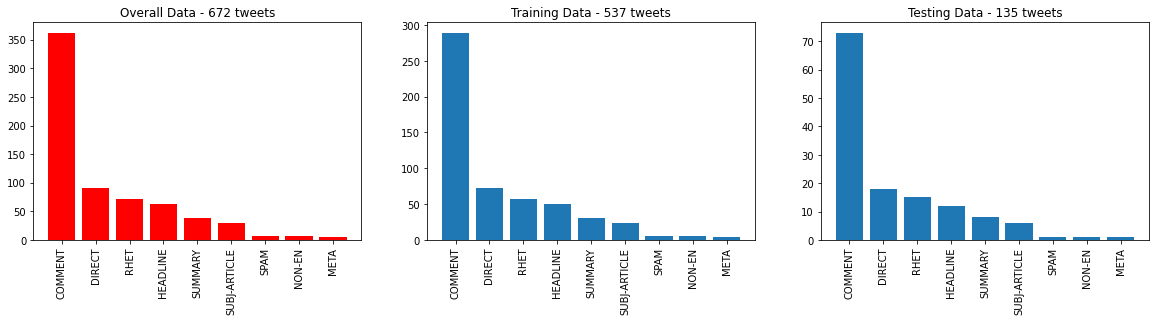

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
y_all = pd.concat([y_train,y_test])
value = y_all.value_counts()
axes[0].bar(range(len(value.values)), value.values, color='r')
axes[0].set_xticks(np.arange(len(value.index)))
axes[0].set_xticklabels(return_labels(value.index), rotation='vertical')
axes[0].set_title('Overall Data - '+ str(len(y_all))+' tweets')

value = y_train.value_counts()
axes[1].bar(range(len(value.values)), value.values)
axes[1].set_xticks(np.arange(len(value.index)))
axes[1].set_xticklabels(return_labels(value.index), rotation='vertical')
axes[1].set_title('Training Data - '+ str(len(y_train))+' tweets')

value = y_test.value_counts()
axes[2].bar(range(len(value.values)), value.values)
axes[2].set_xticks(np.arange(len(value.index)))
axes[2].set_xticklabels(return_labels(value.index), rotation='vertical')
axes[2].set_title('Testing Data - '+ str(len(y_test))+' tweets')

plt.show()

# axes[0].set_xticks(range(8),return_labels(value.index))
# b = plot_results(true, pred, classes=classes, normalize=None,ax=ax12)
# ax12.set_title('Counts Confusion Matrix')
# axes[0] = y_train.value_counts().plot(kind='bar')
# axes[0] = value.plot.bar(x=return_labels(value.index), y=value.values)


In [0]:
# X_train[:5]

In [0]:
y_train = y_train.to_numpy()

In [0]:
bert_inputs = _get_inputs(X_train,tokenizer=bert_tokenizer_tfhub,_maxlen=180, verbose=1)
# bert_inputs = convert_to_features(X_train,bert_tokenizer,120)

[CLS] it is a baby after all . [SEP] the senate is voting on a week abortion ban . opponents say it s basically relying on junk science . [SEP]
[CLS] restrictions like these punish women and target low income women and people of color . [SEP] the senate is voting on a week abortion ban . opponents say it s basically relying on junk science . [SEP]
[CLS] she is fearless ! [SEP] twitter blocks marsh ##a blackburn senate announcement because of her pro life stance [SEP]


In [0]:
test_bert_inputs = _get_inputs(X_test,tokenizer=bert_tokenizer_tfhub,_maxlen=180, verbose=1)
# test_bert_inputs = convert_to_features(X_test,bert_tokenizer,120)

[CLS] sunday political talk shows completely ignored tr ##u . . . [SEP] sunday political talk shows completely ignored trump white house officials use of private email accounts [SEP]
[CLS] really ? [SEP] twitter blocks marsh ##a blackburn senate announcement because of her pro life stance [SEP]
[CLS] . . but house ##go ##p is attacking women s health amp choice right now ? [SEP] the senate is voting on a week abortion ban . opponents say it s basically relying on junk science . [SEP]


In [0]:
y_test = y_test.to_numpy()

In [0]:
Xtr_bert, Xtr_bert_word = bert_layer(bert_inputs)

In [0]:
Xtst_bert,Xtst_bert_word = bert_layer(test_bert_inputs)

In [0]:
print('Xtr_bert Shape : ',Xtr_bert.shape)
print('Xtr_bert_word Shape : ',Xtr_bert_word.shape)
print('Xtst_bert Shape : ',Xtst_bert.shape)
print('Xtst_bert_word Shape : ',Xtst_bert_word.shape)

Xtr_bert Shape :  (537, 768)
Xtr_bert_word Shape :  (537, 180, 768)
Xtst_bert Shape :  (135, 768)
Xtst_bert_word Shape :  (135, 180, 768)


In [0]:
# df_filtered['Label'].value_counts().plot(kind='bar')

### Model 1; Use sentence embeddings; Inputs are the three vectors (tokens, masks and segments). Takes long to train, not used

#### Model Training

In [0]:
# def build_model_fullyconnected(MAX_SEQUENCE_LENGTH = 200):
#     """add pretrained bert model as a keras layer"""
#     input_word_ids = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
#     input_masks = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
#     input_segments = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')
#     sout, _word_emb = bert_layer([input_word_ids, input_masks, input_segments])
#     X= Dense(100, activation='relu')(sout) 
#     X= Dense(64, activation='relu')(X) 
#     # X = GlobalAveragePooling1D()(X)
#     output_= Dense(len(categories), activation='softmax', name='output')(X)

#     #model = Model(input_,output_)
#     model = Model([input_word_ids, input_masks, input_segments],output_)
#     print(model.summary())

#     return model

In [0]:
# model1 = model1 = build_model_fullyconnected()

# model1.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
#               metrics=['acc'])

# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=20, verbose=0)
# cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
#                                              save_best_only=True, monitor='acc', mode='min')

# history1 = model1.fit(bert_inputs, y_train, epochs=50, verbose=2, 
#                      callbacks=[earlyStopping, cp_save] )
#                     #  ,validation_split=0.2 )

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_masks[0][0]         

537/537 - 463s - loss: 1.6896 - acc: 0.5047
Epoch 2/50


537/537 - 456s - loss: 1.4914 - acc: 0.5400
Epoch 3/50


537/537 - 463s - loss: 1.4884 - acc: 0.5400
Epoch 4/50


537/537 - 460s - loss: 1.4813 - acc: 0.5400
Epoch 5/50


537/537 - 463s - loss: 1.4841 - acc: 0.5400
Epoch 6/50


537/537 - 463s - loss: 1.4727 - acc: 0.5400
Epoch 7/50


537/537 - 463s - loss: 1.4733 - acc: 0.5400
Epoch 8/50


537/537 - 457s - loss: 1.4772 - acc: 0.5400
Epoch 9/50


537/537 - 458s - loss: 1.4832 - acc: 0.5400
Epoch 10/50


537/537 - 457s - loss: 1.4870 - acc: 0.5400
Epoch 11/50


537/537 - 463s - loss: 1.4734 - acc: 0.5400
Epoch 12/50


537/537 - 468s - loss: 1.4725 - acc: 0.5400
Epoch 13/50


537/537 - 468s - loss: 1.4683 - acc: 0.5400
Epoch 14/50


537/537 - 480s - loss: 1.4616 - acc: 0.5400
Epoch 15/50


537/537 - 481s - loss: 1.4701 - acc: 0.5400
Epoch 16/50


537/537 - 480s - loss: 1.4610 - acc: 0.5400
Epoch 17/50


537/537 - 477s - loss: 1.4645 - acc: 0.5400
Epoch 18/50


537/537 - 481s - loss: 1.4680 - acc: 0.5400
Epoch 19/50


537/537 - 481s - loss: 1.4693 - acc: 0.5400
Epoch 20/50


537/537 - 479s - loss: 1.4607 - acc: 0.5400
Epoch 21/50


537/537 - 487s - loss: 1.4578 - acc: 0.5400
Epoch 22/50


537/537 - 490s - loss: 1.4550 - acc: 0.5400
Epoch 23/50


537/537 - 484s - loss: 1.4625 - acc: 0.5400
Epoch 24/50


537/537 - 484s - loss: 1.4552 - acc: 0.5400
Epoch 25/50


537/537 - 489s - loss: 1.4677 - acc: 0.5400
Epoch 26/50


537/537 - 485s - loss: 1.4508 - acc: 0.5400
Epoch 27/50


537/537 - 486s - loss: 1.4453 - acc: 0.5400
Epoch 28/50


537/537 - 487s - loss: 1.4544 - acc: 0.5400
Epoch 29/50


537/537 - 488s - loss: 1.4537 - acc: 0.5400
Epoch 30/50


537/537 - 488s - loss: 1.4510 - acc: 0.5400
Epoch 31/50


537/537 - 493s - loss: 1.4450 - acc: 0.5400
Epoch 32/50


537/537 - 493s - loss: 1.4497 - acc: 0.5400
Epoch 33/50


537/537 - 494s - loss: 1.4413 - acc: 0.5400
Epoch 34/50


537/537 - 492s - loss: 1.4439 - acc: 0.5400
Epoch 35/50


537/537 - 487s - loss: 1.4399 - acc: 0.5400
Epoch 36/50


537/537 - 490s - loss: 1.4433 - acc: 0.5400
Epoch 37/50


537/537 - 491s - loss: 1.4378 - acc: 0.5400
Epoch 38/50


537/537 - 484s - loss: 1.4422 - acc: 0.5400
Epoch 39/50


537/537 - 483s - loss: 1.4465 - acc: 0.5400
Epoch 40/50


537/537 - 478s - loss: 1.4443 - acc: 0.5400
Epoch 41/50


537/537 - 475s - loss: 1.4406 - acc: 0.5400
Epoch 42/50


In [0]:
# type(y_train)

### Model 2; Use sentence embeddings; Inputs is the bert layer output run separately

#### Model Training

In [0]:
def build_model_bertembed(MAX_SEQUENCE_LENGTH = 180):

    input_ = Input(shape = (768), name='bert_enconding')
    X= Dense(100, activation='relu')(input_) 
    X= Dense(64, activation='relu')(X) 
    # X = GlobalAveragePooling1D()(X)
    output_= Dense(len(categories), activation='softmax', name='output')(X)
    
    model = Model(input_,output_)
    print(model.summary())
    return model

In [0]:
model2 = build_model_bertembed()

model2.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history2 = model2.fit(Xtr_bert, y_train, epochs=300, batch_size=3)

# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)
# cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
#                                              save_best_only=True, monitor='loss', mode='min')

# history2 = model2.fit(Xtr_bert, y_train, epochs=500, verbose=2, 
#                      callbacks=[earlyStopping, cp_save]
#                       , validation_split=0.1 )



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert_enconding (InputLayer)  [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               76900     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
output (Dense)               (None, 9)                 585       
Total params: 83,949
Trainable params: 83,949
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
179/179 [==============================] - 0s 2ms/step - loss: 1.5755 - acc: 0.5121
Epoch 2/300
179/179 [==============================] - 0s 2ms/step - loss: 1.5231 - acc: 0.5158
Epoch 3/300
179/179 [==============================] - 0s 

#### Model Evaluation; Confusion Matrix

In [0]:
## Accuracy and Loss on test dataset
model2.evaluate(Xtst_bert, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 2.3260 - acc: 0.5556


[2.3260180950164795, 0.5555555820465088]

In [0]:
comb_results = gen_combined_results(X_test, model2 ,Xtst_bert, y_test)

In [0]:
## Sample results

print('Results Data frame; Actual Label -', list(comb_results['true_Label'][:10].values))
print('Results Data frame; Predicted Label -', list(comb_results['pred_Label'][:10].values))


Results Data frame; Actual Label - ['HEADLINE', 'RHET', 'RHET', 'COMMENT', 'DIRECT', 'COMMENT', 'COMMENT', 'DIRECT', 'RHET', 'COMMENT']
Results Data frame; Predicted Label - ['HEADLINE', 'RHET', 'COMMENT', 'COMMENT', 'COMMENT', 'COMMENT', 'META', 'COMMENT', 'COMMENT', 'COMMENT']


In [0]:
## Unique Predictions

print(np.unique(comb_results['pred_Label']))


['COMMENT' 'DIRECT' 'HEADLINE' 'META' 'RHET' 'SUBJ-ARTICLE' 'SUMMARY']


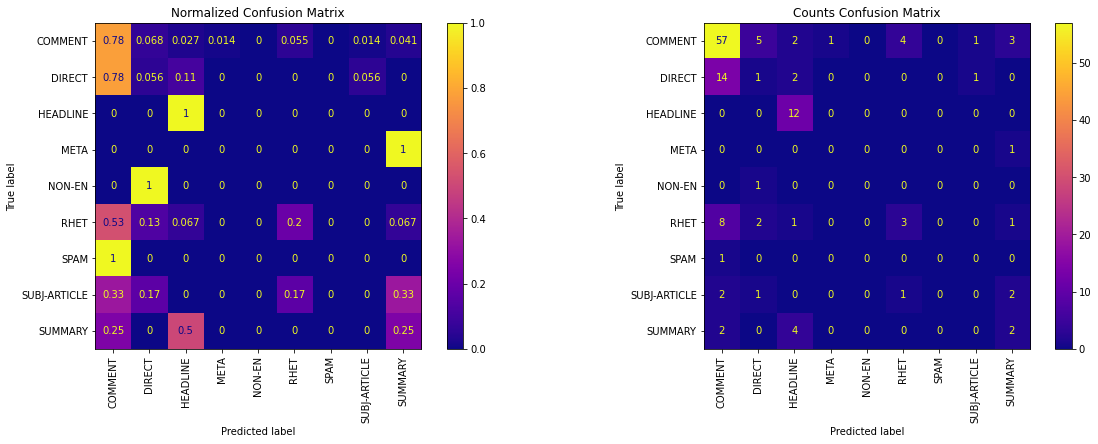

In [0]:
## Confusion Matrix
true = comb_results['true_Label']
pred = comb_results['pred_Label']
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= plot_results(true, pred, classes=classes, normalize='true',ax=ax11)
ax11.set_title('Normalized Confusion Matrix')
b = plot_results(true, pred, classes=classes, normalize=None,ax=ax12)
ax12.set_title('Counts Confusion Matrix')
plt.show()

#### Sample Results

In [0]:
comb_results[comb_results['Label'] ==comb_results['pred_Label']].head()

,Text,News headline,Label,true_Label,target,pred_target,pred_Label
227,Sunday political talk shows completely ignored Tru...,Sunday political talk shows completely ignored Trump White House officials use of private email accounts,HEADLINE,HEADLINE,2,2,HEADLINE
414,Really?,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,RHET,RHET,5,5,RHET
557,More social media bias...,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,COMMENT,COMMENT,0,0,COMMENT
469,They blocked her because they are sexist.,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,COMMENT,COMMENT,0,0,COMMENT
572,Shut down for Anti PP Remarks!,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,COMMENT,COMMENT,0,0,COMMENT


In [0]:
comb_results[comb_results['Label'] !=comb_results['pred_Label']].head()

,Text,News headline,Label,true_Label,target,pred_target,pred_Label
160,..but HouseGOP is attacking women s health amp choice right now?,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,RHET,RHET,5,0,COMMENT
360,Hi Twitter F F B Stop blocking free speech.,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,DIRECT,DIRECT,1,0,COMMENT
633,For the file,"Op Ed Contributor When It Comes to Surveillance, Watch the Watchmen",COMMENT,COMMENT,0,3,META
72,"Shame on you GOP for wasting our time, shaming women, amp running away from GunSafety policy. via voxdotcom",The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,DIRECT,DIRECT,1,0,COMMENT
405,A tech company with NO MORAL COMPASS has the audacity to censor?!?,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,RHET,RHET,5,0,COMMENT


#### Actual Vs Prediction distribution

In [0]:
values, counts = np.unique(true, return_counts=True)
values_pred, counts_pred = np.unique(pred, return_counts=True)

In [0]:
pd_true = pd.DataFrame(columns=['label','count'])
pd_pred = pd.DataFrame(columns=['label','count'])

pd_true['label']=values
pd_true['counts']=counts
pd_true['type']='Actual'
pd_pred['label']=values_pred
pd_pred['counts']=counts_pred
pd_pred['type']='Prediction'

pd_results = pd.concat([pd_true, pd_pred])


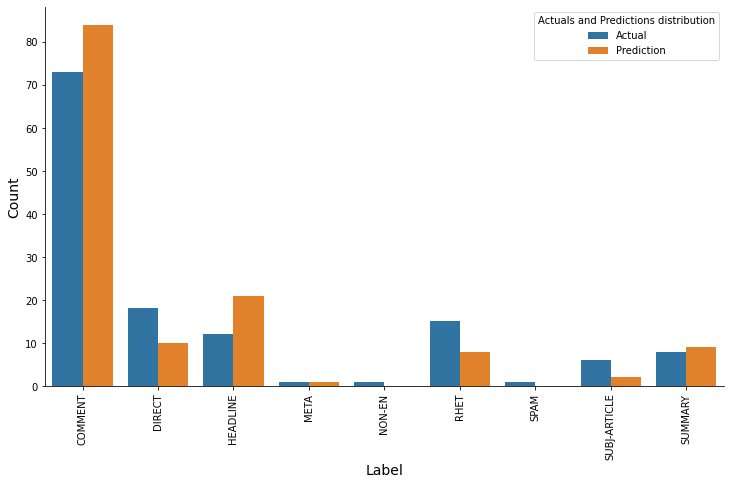

In [0]:
sn.catplot(data=pd_results, x='label', y='counts', hue='type', kind='bar', height=6, aspect=1.7, legend=False)
plt.xticks(rotation=90)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Actuals and Predictions distribution')
plt.show()

#### Another way of presenting confusion matrix

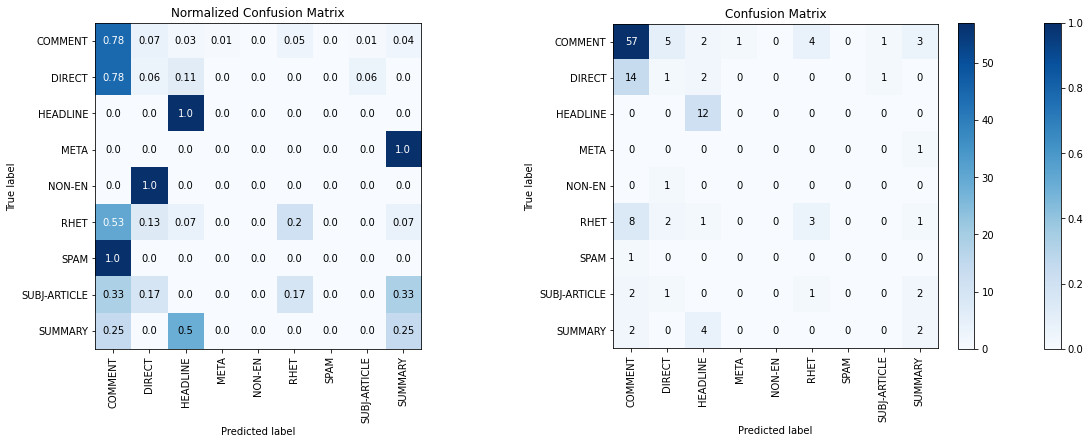

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= skplt.metrics.plot_confusion_matrix(true, pred, normalize=True,x_tick_rotation=90,ax=ax11)
b = skplt.metrics.plot_confusion_matrix(true, pred, normalize=None,x_tick_rotation=90,ax=ax12)
plt.show()

### Model 3; Use WORD embeddings; Input is the bert layer output run separately

In [0]:
def build_model_word_bertembed(MAX_SEQUENCE_LENGTH = 180):

    input_ = Input(shape = (MAX_SEQUENCE_LENGTH,768), name='bert_enconding')
    X= Dense(100, activation='relu')(input_) 
    X = GlobalAveragePooling1D()(X)
    X= Dense(64, activation='relu')(X) 
    output_= Dense(len(categories), activation='softmax', name='output')(X)
    
    model = Model(input_,output_)
    print(model.summary())
    return model

In [0]:
model3 = build_model_word_bertembed()

model3.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history3 = model3.fit(Xtr_bert_word, y_train, epochs=60, batch_size=3)

# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)
# cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
#                                              save_best_only=True, monitor='loss', mode='min')

# history3 = model3.fit(Xtr_bert_word, y_train, epochs=600, verbose=2, 
#                      callbacks=[earlyStopping, cp_save]
#                       , validation_split=0.1 )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert_enconding (InputLayer)  [(None, 180, 768)]        0         
_________________________________________________________________
dense_2 (Dense)              (None, 180, 100)          76900     
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6464      
_________________________________________________________________
output (Dense)               (None, 9)                 585       
Total params: 83,949
Trainable params: 83,949
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
179/179 [==============================] - 1s 7ms/step - loss: 1.3247 - acc: 0.5754
Epoch 2/60
179/179 [=

#### Model Evaluation; Confusion Matrix

In [0]:
## Accuracy and Loss on test dataset
model3.evaluate(Xtst_bert_word, y_test)

5/5 [==============================] - 0s 16ms/step - loss: 1.7843 - acc: 0.7630


[1.784264326095581, 0.7629629373550415]

In [0]:
comb_results = gen_combined_results(X_test, model3 ,Xtst_bert_word, y_test)

In [0]:
## Sample results

print('Results Data frame; Actual Label -', list(comb_results['true_Label'][:10].values))
print('Results Data frame; Predicted Label -', list(comb_results['pred_Label'][:10].values))


Results Data frame; Actual Label - ['HEADLINE', 'RHET', 'RHET', 'COMMENT', 'DIRECT', 'COMMENT', 'COMMENT', 'DIRECT', 'RHET', 'COMMENT']
Results Data frame; Predicted Label - ['COMMENT', 'RHET', 'RHET', 'COMMENT', 'DIRECT', 'COMMENT', 'COMMENT', 'COMMENT', 'COMMENT', 'COMMENT']


In [0]:
## Unique Predictions

print(np.unique(comb_results['pred_Label']))


['COMMENT' 'DIRECT' 'HEADLINE' 'NON-EN' 'RHET' 'SUBJ-ARTICLE' 'SUMMARY']


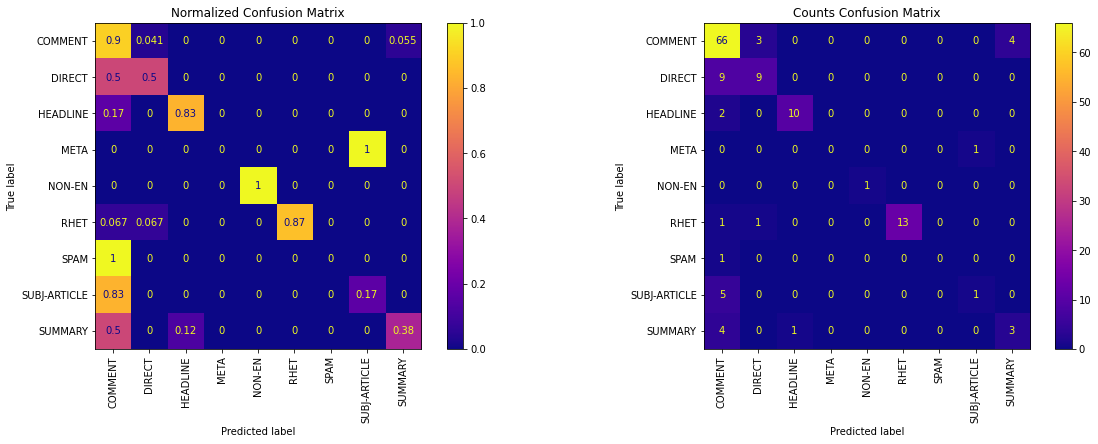

In [0]:
## Confusion Matrix
true = comb_results['true_Label']
pred = comb_results['pred_Label']
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= plot_results(true, pred, classes=classes, normalize='true',ax=ax11)
ax11.set_title('Normalized Confusion Matrix')
b = plot_results(true, pred, classes=classes, normalize=None,ax=ax12)
ax12.set_title('Counts Confusion Matrix')
plt.show()

#### Sample Results

In [0]:
comb_results[comb_results['Label'] ==comb_results['pred_Label']].head()

,Text,News headline,Label,true_Label,target,pred_target,pred_Label
414,Really?,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,RHET,RHET,5,5,RHET
160,..but HouseGOP is attacking women s health amp choice right now?,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,RHET,RHET,5,5,RHET
557,More social media bias...,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,COMMENT,COMMENT,0,0,COMMENT
360,Hi Twitter F F B Stop blocking free speech.,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,DIRECT,DIRECT,1,1,DIRECT
469,They blocked her because they are sexist.,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,COMMENT,COMMENT,0,0,COMMENT


In [0]:
comb_results[comb_results['Label'] !=comb_results['pred_Label']].head()

,Text,News headline,Label,true_Label,target,pred_target,pred_Label
227,Sunday political talk shows completely ignored Tru...,Sunday political talk shows completely ignored Trump White House officials use of private email accounts,HEADLINE,HEADLINE,2,0,COMMENT
72,"Shame on you GOP for wasting our time, shaming women, amp running away from GunSafety policy. via voxdotcom",The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,DIRECT,DIRECT,1,0,COMMENT
405,A tech company with NO MORAL COMPASS has the audacity to censor?!?,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,RHET,RHET,5,0,COMMENT
533,"RT if u AGREE amp want to spread this like wildfire, faster than it can be removed E D A F F F F F F F F BA F F B F",Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,DIRECT,DIRECT,1,0,COMMENT
559,.BLOCKED ad for Blackburn Senate run bc she s against PP SELLING BABYPARTS .,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,SUMMARY,SUMMARY,8,0,COMMENT


#### Actual Vs Prediction distribution

In [0]:
values, counts = np.unique(true, return_counts=True)
values_pred, counts_pred = np.unique(pred, return_counts=True)

In [0]:
pd_true = pd.DataFrame(columns=['label','count'])
pd_pred = pd.DataFrame(columns=['label','count'])

pd_true['label']=values
pd_true['counts']=counts
pd_true['type']='Actual'
pd_pred['label']=values_pred
pd_pred['counts']=counts_pred
pd_pred['type']='Prediction'

pd_results = pd.concat([pd_true, pd_pred])


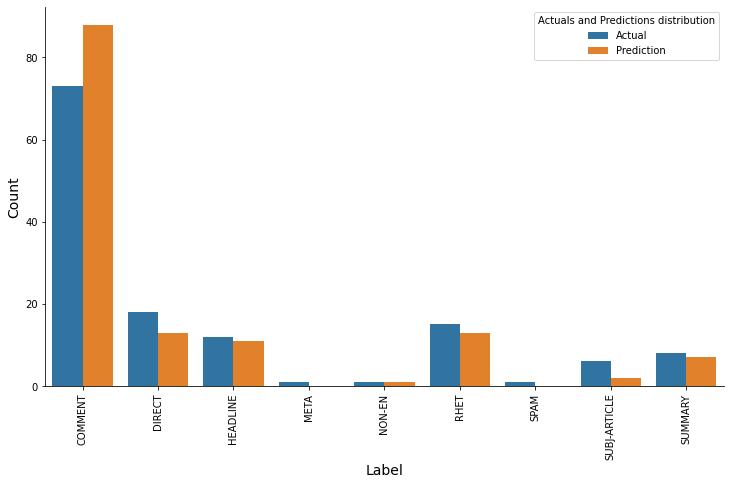

In [0]:
sn.catplot(data=pd_results, x='label', y='counts', hue='type', kind='bar', height=6, aspect=1.7, legend=False)
plt.xticks(rotation=90)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Actuals and Predictions distribution')
plt.show()

#### Another way of presenting confusion matrix

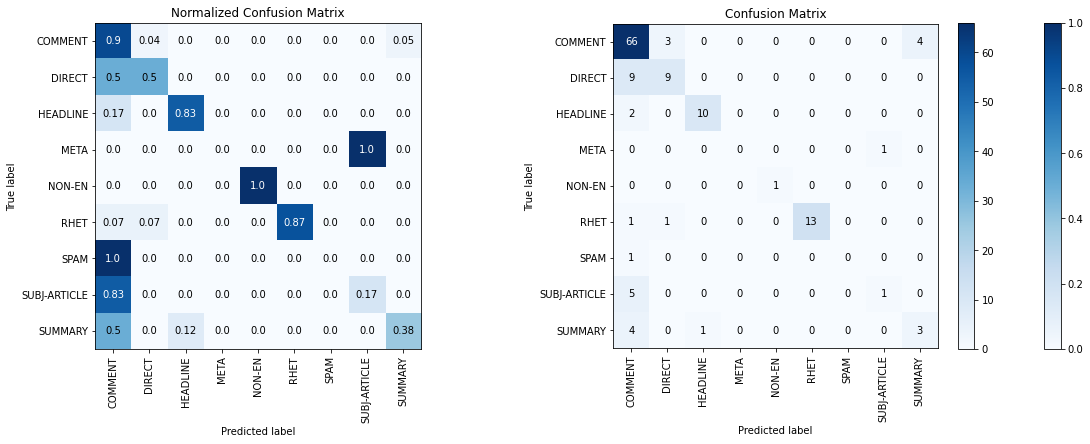

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= skplt.metrics.plot_confusion_matrix(true, pred, normalize=True,x_tick_rotation=90,ax=ax11)
b = skplt.metrics.plot_confusion_matrix(true, pred, normalize=None,x_tick_rotation=90,ax=ax12)
plt.show()

## BERT - Comments Vs Others Classification

### Data preprocessing
Remove Special Characters  
Create Train and test datasets  
Convert them to Bert inputs

In [0]:
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/raw/news-url-data-annotated-4-19-2020.csv

--2020-05-03 17:54:43--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/raw/news-url-data-annotated-4-19-2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209597 (205K) [text/plain]
Saving to: ‘news-url-data-annotated-4-19-2020.csv.2’

news-url-data-annot 100%[===================>] 204.68K  --.-KB/s    in 0.03s   

2020-05-03 17:54:43 (7.24 MB/s) - ‘news-url-data-annotated-4-19-2020.csv.2’ saved [209597/209597]



In [0]:
df = pd.read_csv("news-url-data-annotated-4-19-2020.csv")
# df.head()

In [0]:
#pre-precess data to remove numbers & 
df['Text'] = df['Text'].astype(str).apply(preprocess)
df['News headline'] = df['News headline'].astype(str).apply(preprocess)
df.Label = df.Label.str.rstrip()

In [0]:
# filter out certain labels such as Quote
df_filtered = df[(df['Label'] != 'QUOTE') & (df['Label'] != 'I am disappointed in twitter censorship https://t.co/vFAEUUv70N') & (df.Label.notnull()) & (df['Label'] != 'COMMENT + RHET')]

In [0]:
df_filtered['Label'] = df_filtered['Label'].astype(str).apply(label_transform)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_filtered.Label.astype('category').cat.codes.unique()

array([0, 1], dtype=int8)

In [0]:
df_filtered.Label.unique()

array(['COMMENT', 'OTHER'], dtype=object)

In [0]:
cat_codes = list(df_filtered.Label.astype('category').cat.codes.unique())

In [0]:
categories = list(df_filtered.Label.unique())
classes = sorted(categories)

In [0]:
dict_cat = {}
for i in range(len(cat_codes)):
  dict_cat[cat_codes[i]] = categories[i]

In [0]:
dict_cat

{0: 'COMMENT', 1: 'OTHER'}

In [0]:
df_filtered['target'] = df_filtered.Label.astype('category').cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_filtered.head()

,Label,Text,Tweet,News headline,target
0,COMMENT,Ironic voxdotcom attempts to discredit science when it suits their pro abortion agenda vs their abdication on scientific doubt on climate,Ironic @voxdotcom attempts to discredit science when it suits their pro-abortion agenda vs their abdication on scientific doubt on climate https://t.co/b69zExIqOz,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,0
1,OTHER,reproductiverights abortionrights,#reproductiverights #abortionrights https://t.co/ZcgSotKl4B,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,1
2,COMMENT,i feel like this issue boils down to at what point do we recognize this organism as a human life with rights sgsx,"i feel like this issue boils down to at what point do we recognize this ""organism"" as a human life with rights #sgsx15 https://t.co/qjV1RxMm7J",The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,0
3,COMMENT,I stg they just pick a random number from a hat and make claims about it as if they know a SINGLE thing about the subject,I stg they just pick a random number from a hat and make claims about it as if they know a SINGLE thing about the subject https://t.co/0uGeEsQWIf,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,0
4,COMMENT,"Maybe you can t regulate evil, but it sure looks like you can elect it to office.","Maybe you can't regulate evil, but it sure looks like you can elect it to office. https://t.co/tXxN6vEAby",The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,0


**Data Split**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered[['Text','News headline','Label']], df_filtered['target'], test_size=0.2, 
                                                    random_state = 0, stratify = df_filtered['target'])

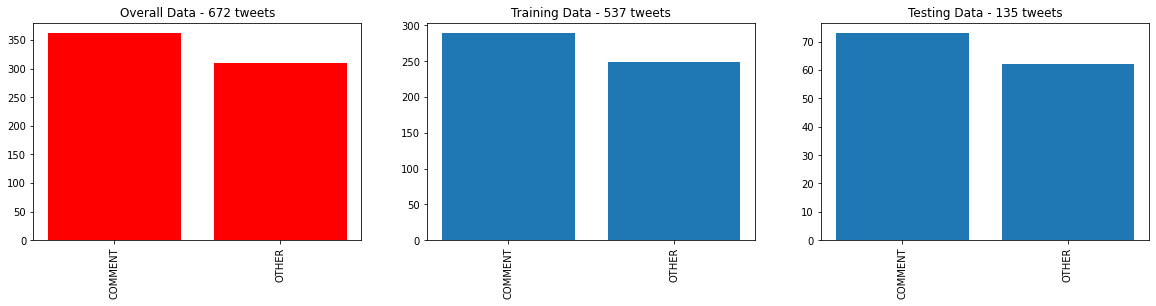

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
y_all = pd.concat([y_train,y_test])
value = y_all.value_counts()
axes[0].bar(range(len(value.values)), value.values, color='r')
axes[0].set_xticks(np.arange(len(value.index)))
axes[0].set_xticklabels(return_labels(value.index), rotation='vertical')
axes[0].set_title('Overall Data - '+ str(len(y_all))+' tweets')

value = y_train.value_counts()
axes[1].bar(range(len(value.values)), value.values)
axes[1].set_xticks(np.arange(len(value.index)))
axes[1].set_xticklabels(return_labels(value.index), rotation='vertical')
axes[1].set_title('Training Data - '+ str(len(y_train))+' tweets')

value = y_test.value_counts()
axes[2].bar(range(len(value.values)), value.values)
axes[2].set_xticks(np.arange(len(value.index)))
axes[2].set_xticklabels(return_labels(value.index), rotation='vertical')
axes[2].set_title('Testing Data - '+ str(len(y_test))+' tweets')

plt.show()

# axes[0].set_xticks(range(8),return_labels(value.index))
# b = plot_results(true, pred, classes=classes, normalize=None,ax=ax12)
# ax12.set_title('Counts Confusion Matrix')
# axes[0] = y_train.value_counts().plot(kind='bar')
# axes[0] = value.plot.bar(x=return_labels(value.index), y=value.values)


In [0]:
# X_train[:5]

In [0]:
y_train = y_train.to_numpy()

In [0]:
bert_inputs = _get_inputs(X_train,tokenizer=bert_tokenizer_tfhub,_maxlen=180, verbose=1)
# bert_inputs = convert_to_features(X_train,bert_tokenizer,120)

[CLS] preach girl ! [SEP] the senate is voting on a week abortion ban . opponents say it s basically relying on junk science . [SEP]
[CLS] left ##est rule ! . . . sadly [SEP] twitter blocks marsh ##a blackburn senate announcement because of her pro life stance [SEP]
[CLS] chuck ##to ##dd , gs ##te ##pha ##no ##poulos , face ##the ##nation , fox ##ne ##ws ##sund ##ay , cnn ##so ##tu . how about it guys ? . [SEP] sunday political talk shows completely ignored trump white house officials use of private email accounts [SEP]


In [0]:
test_bert_inputs = _get_inputs(X_test,tokenizer=bert_tokenizer_tfhub,_maxlen=180, verbose=1)
# test_bert_inputs = convert_to_features(X_test,bert_tokenizer,120)

[CLS] why do you people wanna continue killing kids but control all the guns . [SEP] the senate is voting on a week abortion ban . opponents say it s basically relying on junk science . [SEP]
[CLS] not even harvey can stop it ! [SEP] houston s un ##sin ##ka ##ble housing market und ##au ##nted by storm [SEP]
[CLS] the fact that planned parent ##hood harvest ##s fetal organs is too hot for twitter . [SEP] twitter blocks marsh ##a blackburn senate announcement because of her pro life stance [SEP]


In [0]:
y_test = y_test.to_numpy()

In [0]:
Xtr_bert, Xtr_bert_word = bert_layer(bert_inputs)

In [0]:
Xtst_bert,Xtst_bert_word = bert_layer(test_bert_inputs)

In [0]:
print('Xtr_bert Shape : ',Xtr_bert.shape)
print('Xtr_bert_word Shape : ',Xtr_bert_word.shape)
print('Xtst_bert Shape : ',Xtst_bert.shape)
print('Xtst_bert_word Shape : ',Xtst_bert_word.shape)

Xtr_bert Shape :  (537, 768)
Xtr_bert_word Shape :  (537, 180, 768)
Xtst_bert Shape :  (135, 768)
Xtst_bert_word Shape :  (135, 180, 768)


In [0]:
# df_filtered['Label'].value_counts().plot(kind='bar')

### Model 1; Use sentence embeddings; Inputs are the three vectors (tokens, masks and segments). Takes long to train, not used

#### Model Training

In [0]:
# def build_model_fullyconnected(MAX_SEQUENCE_LENGTH = 200):
#     """add pretrained bert model as a keras layer"""
#     input_word_ids = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
#     input_masks = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
#     input_segments = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')
#     sout, _word_emb = bert_layer([input_word_ids, input_masks, input_segments])
#     X= Dense(100, activation='relu')(sout) 
#     X= Dense(64, activation='relu')(X) 
#     # X = GlobalAveragePooling1D()(X)
#     output_= Dense(len(categories), activation='softmax', name='output')(X)

#     #model = Model(input_,output_)
#     model = Model([input_word_ids, input_masks, input_segments],output_)
#     print(model.summary())

#     return model

In [0]:
# model1 = model1 = build_model_fullyconnected()

# model1.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
#               metrics=['acc'])

# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=20, verbose=0)
# cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
#                                              save_best_only=True, monitor='acc', mode='min')

# history1 = model1.fit(bert_inputs, y_train, epochs=50, verbose=2, 
#                      callbacks=[earlyStopping, cp_save] )
#                     #  ,validation_split=0.2 )

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_masks[0][0]         

537/537 - 463s - loss: 1.6896 - acc: 0.5047
Epoch 2/50


537/537 - 456s - loss: 1.4914 - acc: 0.5400
Epoch 3/50


537/537 - 463s - loss: 1.4884 - acc: 0.5400
Epoch 4/50


537/537 - 460s - loss: 1.4813 - acc: 0.5400
Epoch 5/50


537/537 - 463s - loss: 1.4841 - acc: 0.5400
Epoch 6/50


537/537 - 463s - loss: 1.4727 - acc: 0.5400
Epoch 7/50


537/537 - 463s - loss: 1.4733 - acc: 0.5400
Epoch 8/50


537/537 - 457s - loss: 1.4772 - acc: 0.5400
Epoch 9/50


537/537 - 458s - loss: 1.4832 - acc: 0.5400
Epoch 10/50


537/537 - 457s - loss: 1.4870 - acc: 0.5400
Epoch 11/50


537/537 - 463s - loss: 1.4734 - acc: 0.5400
Epoch 12/50


537/537 - 468s - loss: 1.4725 - acc: 0.5400
Epoch 13/50


537/537 - 468s - loss: 1.4683 - acc: 0.5400
Epoch 14/50


537/537 - 480s - loss: 1.4616 - acc: 0.5400
Epoch 15/50


537/537 - 481s - loss: 1.4701 - acc: 0.5400
Epoch 16/50


537/537 - 480s - loss: 1.4610 - acc: 0.5400
Epoch 17/50


537/537 - 477s - loss: 1.4645 - acc: 0.5400
Epoch 18/50


537/537 - 481s - loss: 1.4680 - acc: 0.5400
Epoch 19/50


537/537 - 481s - loss: 1.4693 - acc: 0.5400
Epoch 20/50


537/537 - 479s - loss: 1.4607 - acc: 0.5400
Epoch 21/50


537/537 - 487s - loss: 1.4578 - acc: 0.5400
Epoch 22/50


537/537 - 490s - loss: 1.4550 - acc: 0.5400
Epoch 23/50


537/537 - 484s - loss: 1.4625 - acc: 0.5400
Epoch 24/50


537/537 - 484s - loss: 1.4552 - acc: 0.5400
Epoch 25/50


537/537 - 489s - loss: 1.4677 - acc: 0.5400
Epoch 26/50


537/537 - 485s - loss: 1.4508 - acc: 0.5400
Epoch 27/50


537/537 - 486s - loss: 1.4453 - acc: 0.5400
Epoch 28/50


537/537 - 487s - loss: 1.4544 - acc: 0.5400
Epoch 29/50


537/537 - 488s - loss: 1.4537 - acc: 0.5400
Epoch 30/50


537/537 - 488s - loss: 1.4510 - acc: 0.5400
Epoch 31/50


537/537 - 493s - loss: 1.4450 - acc: 0.5400
Epoch 32/50


537/537 - 493s - loss: 1.4497 - acc: 0.5400
Epoch 33/50


537/537 - 494s - loss: 1.4413 - acc: 0.5400
Epoch 34/50


537/537 - 492s - loss: 1.4439 - acc: 0.5400
Epoch 35/50


537/537 - 487s - loss: 1.4399 - acc: 0.5400
Epoch 36/50


537/537 - 490s - loss: 1.4433 - acc: 0.5400
Epoch 37/50


537/537 - 491s - loss: 1.4378 - acc: 0.5400
Epoch 38/50


537/537 - 484s - loss: 1.4422 - acc: 0.5400
Epoch 39/50


537/537 - 483s - loss: 1.4465 - acc: 0.5400
Epoch 40/50


537/537 - 478s - loss: 1.4443 - acc: 0.5400
Epoch 41/50


537/537 - 475s - loss: 1.4406 - acc: 0.5400
Epoch 42/50


In [0]:
# type(y_train)

### Model 2; Use sentence embeddings; Inputs is the bert layer output run separately

#### Model Training

In [0]:
def build_model_bertembed(MAX_SEQUENCE_LENGTH = 180):

    input_ = Input(shape = (768), name='bert_enconding')
    X= Dense(100, activation='relu')(input_) 
    X= Dense(64, activation='relu')(X) 
    # X = GlobalAveragePooling1D()(X)
    output_= Dense(len(categories), activation='softmax', name='output')(X)
    
    model = Model(input_,output_)
    print(model.summary())
    return model

In [0]:
model2 = build_model_bertembed()

model2.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history2 = model2.fit(Xtr_bert, y_train, epochs=500, batch_size=3)

# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)
# cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
#                                              save_best_only=True, monitor='loss', mode='min')

# history2 = model2.fit(Xtr_bert, y_train, epochs=500, verbose=2, 
#                      callbacks=[earlyStopping, cp_save]
#                       , validation_split=0.1 )



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert_enconding (InputLayer)  [(None, 768)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               76900     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6464      
_________________________________________________________________
output (Dense)               (None, 2)                 130       
Total params: 83,494
Trainable params: 83,494
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
179/179 [==============================] - 0s 2ms/step - loss: 0.7682 - acc: 0.5605
Epoch 2/500
179/179 [==============================] - 0s 2ms/step - loss: 0.7203 - acc: 0.5847
Epoch 3/500
179/179 [==============================] - 0

#### Model Evaluation; Confusion Matrix

In [0]:
## Accuracy and Loss on test dataset
model2.evaluate(Xtst_bert, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 1.3133 - acc: 0.6815


[1.3132538795471191, 0.6814814805984497]

In [0]:
comb_results = gen_combined_results(X_test, model2 ,Xtst_bert, y_test)

In [0]:
## Sample results

print('Results Data frame; Actual Label -', list(comb_results['true_Label'][:10].values))
print('Results Data frame; Predicted Label -', list(comb_results['pred_Label'][:10].values))


Results Data frame; Actual Label - ['OTHER', 'COMMENT', 'COMMENT', 'OTHER', 'COMMENT', 'OTHER', 'COMMENT', 'OTHER', 'OTHER', 'COMMENT']
Results Data frame; Predicted Label - ['OTHER', 'COMMENT', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'COMMENT', 'COMMENT', 'OTHER', 'OTHER']


In [0]:
## Unique Predictions

print(np.unique(comb_results['pred_Label']))


['COMMENT' 'OTHER']


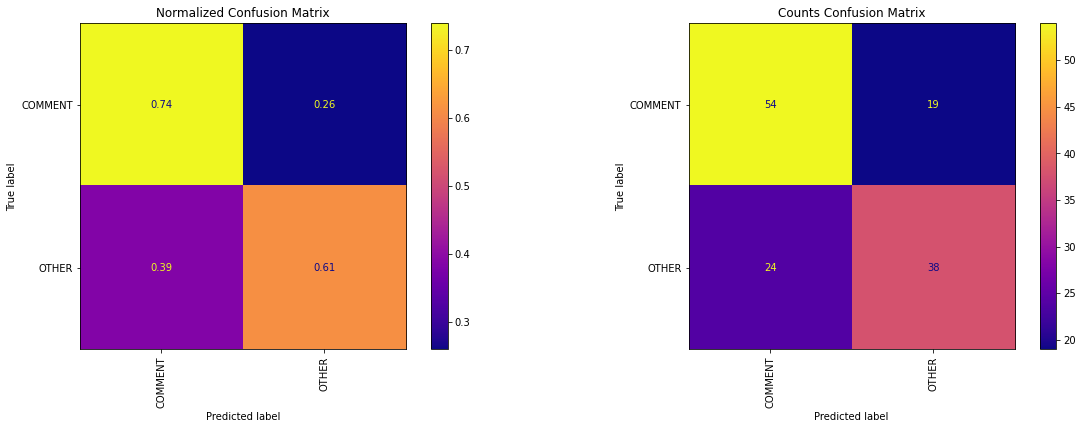

In [0]:
## Confusion Matrix
true = comb_results['true_Label']
pred = comb_results['pred_Label']
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= plot_results(true, pred, classes=classes, normalize='true',ax=ax11)
ax11.set_title('Normalized Confusion Matrix')
b = plot_results(true, pred, classes=classes, normalize=None,ax=ax12)
ax12.set_title('Counts Confusion Matrix')
plt.show()

#### Sample Results

In [0]:
comb_results[comb_results['Label'] ==comb_results['pred_Label']].head()

,Text,News headline,Label,true_Label,target,pred_target,pred_Label
9,Why do you people wanna continue killing kids but control all the guns.,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,OTHER,OTHER,1,1,OTHER
648,Not even Harvey can stop it!,Houston s Unsinkable Housing Market Undaunted by Storm,COMMENT,COMMENT,0,0,COMMENT
149,House will vote on a week abortion ban today. Opponents say it s E C Relying on junk science. E D via voxdotcom,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,OTHER,OTHER,1,1,OTHER
638,Opinion at nytimes,"Op Ed Contributor When It Comes to Surveillance, Watch the Watchmen",OTHER,OTHER,1,1,OTHER
52,Doesn t matter now... the bill is PASSED! ProLife,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,COMMENT,COMMENT,0,0,COMMENT


In [0]:
comb_results[comb_results['Label'] !=comb_results['pred_Label']].head()

,Text,News headline,Label,true_Label,target,pred_target,pred_Label
430,The fact that Planned Parenthood harvests fetal organs is too hot for Twitter.,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,COMMENT,COMMENT,0,1,OTHER
324,MSNBC CNN too busy talking about NFL.,Sunday political talk shows completely ignored Trump White House officials use of private email accounts,COMMENT,COMMENT,0,1,OTHER
166,Also ya it s my bday and no it is not on my profile. Want info on me? read through my shit tweets about pumpkin spice candles nottodayNSA,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,OTHER,OTHER,1,0,COMMENT
535,"Soon, we ll get a promoted tweet in our timelines informing us twitter thinks anything remotely related to abortion is just AWESOME!",Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,COMMENT,COMMENT,0,1,OTHER
86,Like they can t ask the baby type evidence?,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,OTHER,OTHER,1,0,COMMENT


#### Actual Vs Prediction distribution

In [0]:
values, counts = np.unique(true, return_counts=True)
values_pred, counts_pred = np.unique(pred, return_counts=True)

In [0]:
pd_true = pd.DataFrame(columns=['label','count'])
pd_pred = pd.DataFrame(columns=['label','count'])

pd_true['label']=values
pd_true['counts']=counts
pd_true['type']='Actual'
pd_pred['label']=values_pred
pd_pred['counts']=counts_pred
pd_pred['type']='Prediction'

pd_results = pd.concat([pd_true, pd_pred])


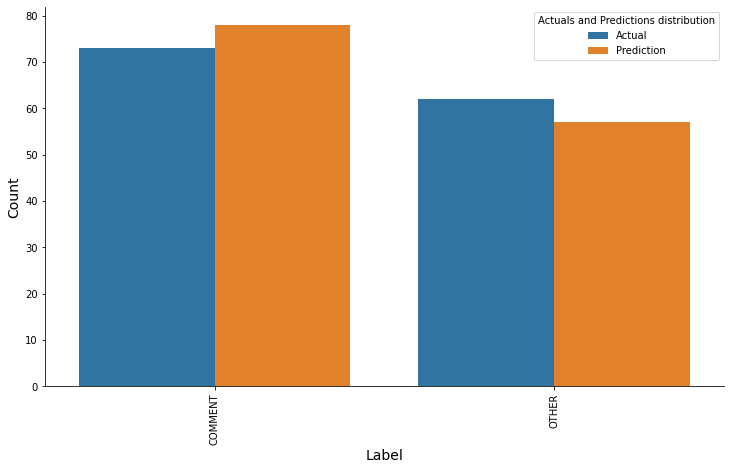

In [0]:
sn.catplot(data=pd_results, x='label', y='counts', hue='type', kind='bar', height=6, aspect=1.7, legend=False)
plt.xticks(rotation=90)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Actuals and Predictions distribution')
plt.show()

#### Another way of presenting confusion matrix

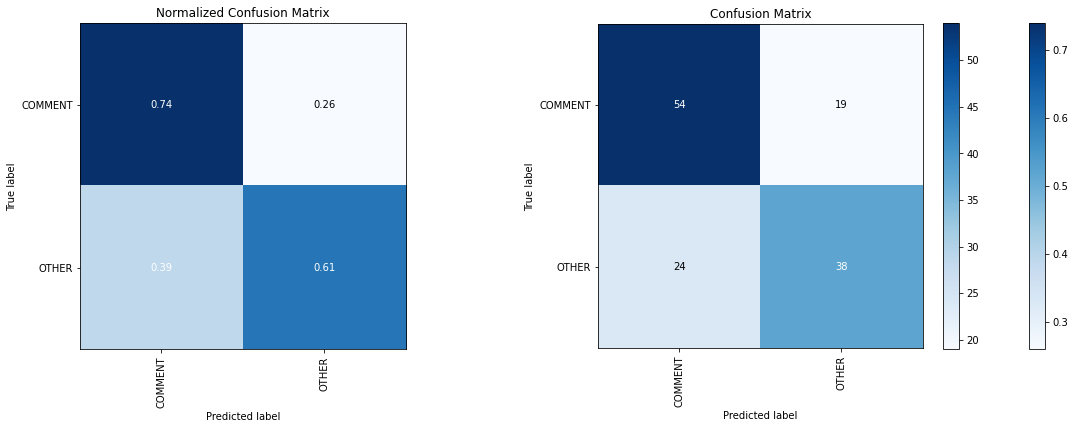

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= skplt.metrics.plot_confusion_matrix(true, pred, normalize=True,x_tick_rotation=90,ax=ax11)
b = skplt.metrics.plot_confusion_matrix(true, pred, normalize=None,x_tick_rotation=90,ax=ax12)
plt.show()

### Model 3; Use WORD embeddings; Input is the bert layer output run separately

In [0]:
def build_model_word_bertembed(MAX_SEQUENCE_LENGTH = 180):

    input_ = Input(shape = (MAX_SEQUENCE_LENGTH,768), name='bert_enconding')
    X= Dense(100, activation='relu')(input_) 
    X = GlobalAveragePooling1D()(X)
    X= Dense(64, activation='relu')(X) 
    output_= Dense(len(categories), activation='softmax', name='output')(X)
    
    model = Model(input_,output_)
    print(model.summary())
    return model

In [0]:
model3 = build_model_word_bertembed()

model3.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history3 = model3.fit(Xtr_bert_word, y_train, epochs=60, batch_size=3)

# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)
# cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
#                                              save_best_only=True, monitor='loss', mode='min')

# history3 = model3.fit(Xtr_bert_word, y_train, epochs=600, verbose=2, 
#                      callbacks=[earlyStopping, cp_save]
#                       , validation_split=0.1 )

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert_enconding (InputLayer)  [(None, 180, 768)]        0         
_________________________________________________________________
dense_6 (Dense)              (None, 180, 100)          76900     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                6464      
_________________________________________________________________
output (Dense)               (None, 2)                 130       
Total params: 83,494
Trainable params: 83,494
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
179/179 [==============================] - 1s 6ms/step - loss: 0.6250 - acc: 0.6629
Epoch 2/60
179/179 [=

#### Model Evaluation; Confusion Matrix

In [0]:
## Accuracy and Loss on test dataset
model3.evaluate(Xtst_bert_word, y_test)

5/5 [==============================] - 0s 15ms/step - loss: 1.8897 - acc: 0.8074


[1.8897253274917603, 0.8074073791503906]

In [0]:
comb_results = gen_combined_results(X_test, model3 ,Xtst_bert_word, y_test)

In [0]:
## Sample results

print('Results Data frame; Actual Label -', list(comb_results['true_Label'][:10].values))
print('Results Data frame; Predicted Label -', list(comb_results['pred_Label'][:10].values))


Results Data frame; Actual Label - ['OTHER', 'COMMENT', 'COMMENT', 'OTHER', 'COMMENT', 'OTHER', 'COMMENT', 'OTHER', 'OTHER', 'COMMENT']
Results Data frame; Predicted Label - ['OTHER', 'OTHER', 'COMMENT', 'OTHER', 'OTHER', 'OTHER', 'COMMENT', 'OTHER', 'COMMENT', 'COMMENT']


In [0]:
## Unique Predictions

print(np.unique(comb_results['pred_Label']))


['COMMENT' 'OTHER']


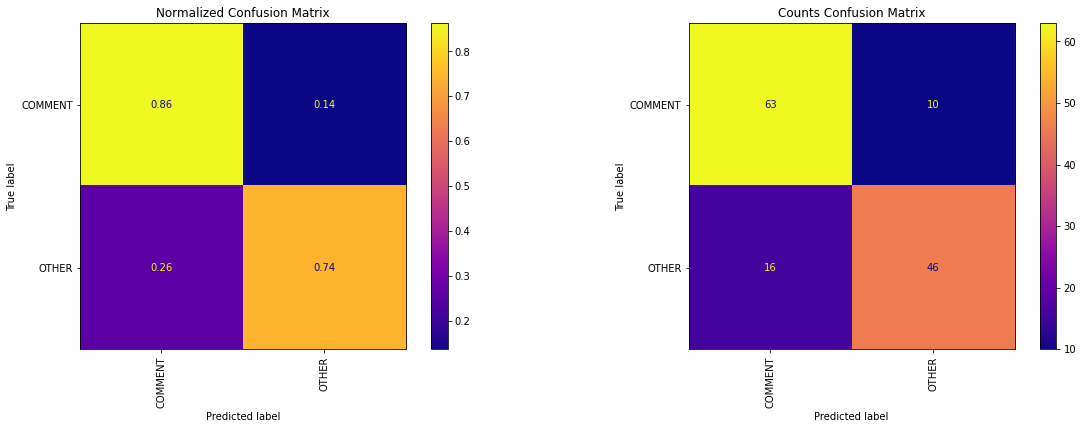

In [0]:
## Confusion Matrix
true = comb_results['true_Label']
pred = comb_results['pred_Label']
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= plot_results(true, pred, classes=classes, normalize='true',ax=ax11)
ax11.set_title('Normalized Confusion Matrix')
b = plot_results(true, pred, classes=classes, normalize=None,ax=ax12)
ax12.set_title('Counts Confusion Matrix')
plt.show()

#### Sample Results

In [0]:
comb_results[comb_results['Label'] ==comb_results['pred_Label']].head()

,Text,News headline,Label,true_Label,target,pred_target,pred_Label
9,Why do you people wanna continue killing kids but control all the guns.,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,OTHER,OTHER,1,1,OTHER
430,The fact that Planned Parenthood harvests fetal organs is too hot for Twitter.,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,COMMENT,COMMENT,0,0,COMMENT
149,House will vote on a week abortion ban today. Opponents say it s E C Relying on junk science. E D via voxdotcom,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,OTHER,OTHER,1,1,OTHER
638,Opinion at nytimes,"Op Ed Contributor When It Comes to Surveillance, Watch the Watchmen",OTHER,OTHER,1,1,OTHER
52,Doesn t matter now... the bill is PASSED! ProLife,The Senate is voting on a week abortion ban. Opponents say it s basically relying on junk science.,COMMENT,COMMENT,0,0,COMMENT


In [0]:
comb_results[comb_results['Label'] !=comb_results['pred_Label']].head()

,Text,News headline,Label,true_Label,target,pred_target,pred_Label
648,Not even Harvey can stop it!,Houston s Unsinkable Housing Market Undaunted by Storm,COMMENT,COMMENT,0,1,OTHER
324,MSNBC CNN too busy talking about NFL.,Sunday political talk shows completely ignored Trump White House officials use of private email accounts,COMMENT,COMMENT,0,1,OTHER
344,Okay POTUS FCC Enough is enough.,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,OTHER,OTHER,1,0,COMMENT
508,They reversed this decision!,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,OTHER,OTHER,1,0,COMMENT
339,Let E s get that trending......,Twitter Blocks Marsha Blackburn Senate Announcement Because of Her Pro Life Stance,OTHER,OTHER,1,0,COMMENT


#### Actual Vs Prediction distribution

In [0]:
values, counts = np.unique(true, return_counts=True)
values_pred, counts_pred = np.unique(pred, return_counts=True)

In [0]:
pd_true = pd.DataFrame(columns=['label','count'])
pd_pred = pd.DataFrame(columns=['label','count'])

pd_true['label']=values
pd_true['counts']=counts
pd_true['type']='Actual'
pd_pred['label']=values_pred
pd_pred['counts']=counts_pred
pd_pred['type']='Prediction'

pd_results = pd.concat([pd_true, pd_pred])


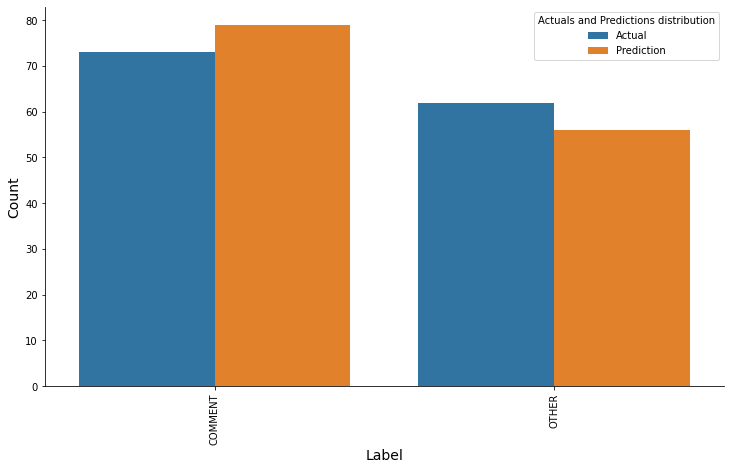

In [0]:
sn.catplot(data=pd_results, x='label', y='counts', hue='type', kind='bar', height=6, aspect=1.7, legend=False)
plt.xticks(rotation=90)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Actuals and Predictions distribution')
plt.show()

#### Another way of presenting confusion matrix

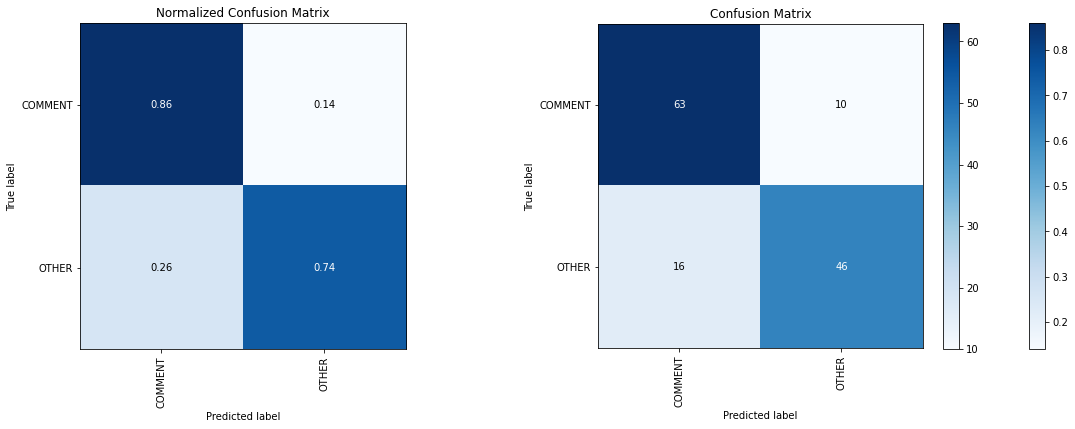

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= skplt.metrics.plot_confusion_matrix(true, pred, normalize=True,x_tick_rotation=90,ax=ax11)
b = skplt.metrics.plot_confusion_matrix(true, pred, normalize=None,x_tick_rotation=90,ax=ax12)
plt.show()

## Glue

### GLUE dataset

In [24]:
import tensorflow_datasets
data = tensorflow_datasets.load("glue/mrpc")

INFO:absl:Load pre-computed datasetinfo (eg: splits) from bucket.
INFO:absl:Loading info from GCS for glue/mrpc/1.0.0
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset glue (/root/tensorflow_datasets/glue/mrpc/1.0.0)


INFO:absl:Downloading https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc into /root/tensorflow_datasets/downloads/fire.goog.com_v0_b_mtl-sent-repr.apps.com_o_2FjSIMlCiqs1QSmIykr4IRPnEHjPuGwAz5i40v8K9U0Z8.tsvalt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc.tmp.bed2b8172fd34e6f9c8e31949b6304b2...
INFO:absl:Downloading https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt into /root/tensorflow_datasets/downloads/dl.fbaip.com_sente_sente_msr_parap_trainfGxPZuQWGBti4Tbd1YNOwQr-OqxPejJ7gcp0Al6mlSk.txt.tmp.eaf6d2d162fa47ecb5967343a16c5be0...
INFO:absl:Downloading https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt into /root/tensorflow_datasets/downloads/dl.fbaip.com_sente_sente_msr_parap_test0PdekMcyqYR-w4Rx_d7OTryq0J3RlYRn4rAMajy9Mak.txt.tmp.20d756e4626b49299e5ee04ee6c29e18...
/usr/local/lib/python3.6/dist-packages/urllib3/co

Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete77YR8Q/glue-train.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete77YR8Q/glue-train.tfrecord. Shard lengths: [3668]
INFO:absl:Generating split validation


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete77YR8Q/glue-validation.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete77YR8Q/glue-validation.tfrecord. Shard lengths: [408]
INFO:absl:Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete77YR8Q/glue-test.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/glue/mrpc/1.0.0.incomplete77YR8Q/glue-test.tfrecord. Shard lengths: [1725]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.AUTO.
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/glue/mrpc/1.0.0


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [0]:
train_dataset = data["train"]
validation_dataset = data["validation"]

In [0]:
# type(train_dataset)

In [0]:
# example = list(train_dataset.__iter__())[0]
# print('',
#     'idx:      ', example['idx'],       '\n',
#     'label:    ', example['label'],     '\n',
#     'sentence1:', example['sentence1'], '\n',
#     'sentence2:', example['sentence2'],
# )

In [0]:
# seq0 = example['sentence1'].numpy().decode('utf-8')  # Obtain bytes from tensor and convert it to a string
# seq1 = example['sentence2'].numpy().decode('utf-8')  # Obtain bytes from tensor and convert it to a string

# print("First sequence:", seq0)
# print("Second sequence:", seq1)

#### Read Training and Test datasets

In [59]:
#Training dataset
df_train = pd.DataFrame(columns=['Text', 'News headline', 'target'])
j=0
for example in list(train_dataset.__iter__()):  
  seq0 = example['sentence1'].numpy().decode('utf-8')
  seq1 = example['sentence2'].numpy().decode('utf-8')
  label = example['label'].numpy().astype(float)
  df_train = df_train.append({'Text':seq0, 'News headline': seq1, 'target':label}, ignore_index=True)
  j =j+1

print('training records', j)

X_train = df_train[['Text','News headline']]
# df_train.target.astype('category').cat.codes.unique()
y_train = df_train['target']
y_train = tf.convert_to_tensor(y_train)


training records 3668


In [0]:
# df_train.target.astype('category').cat.codes.unique()

In [0]:
# y_train = y_train.to_numpy()

In [60]:
#Test dataset
df_test = pd.DataFrame(columns=['Text', 'News headline', 'target'])
j=0
for example in list(validation_dataset.__iter__()):  
  seq0 = example['sentence1'].numpy().decode('utf-8')
  seq1 = example['sentence2'].numpy().decode('utf-8')
  label = example['label'].numpy().astype(float)
  df_test = df_test.append({'Text':seq0, 'News headline': seq1, 'target':label}, ignore_index=True)
  j =j+1

print('test records', j)

X_test = df_test[['Text','News headline']]
X_test = df_test[['Text','News headline']]
y_test = df_test['target']
y_test = tf.convert_to_tensor(y_test)

test records 408


In [0]:
train = pd.Series(np.array(y_train)).astype(int)
test = pd.Series(np.array(y_test)).astype(int)

#### Convert to token, segment and mask inputs. And pass it through bert layer

In [0]:
# trans_bert_inputs = convert_to_features(X_train,bert_tokenizer,120)

*** Example ***
input_ids: 101 1109 6742 187 24985 1209 2496 1112 24628 25166 1116 117 6205 1111 2554 1104 1763 1447 119 102 1109 187 24985 2496 1112 24628 25166 1116 117 2232 1113 1565 8089 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
*** Example ***
input_ids: 101 13568 1190 1406 3029 1104 25941 112 188 3813 1156 1435 1121 1543 17306 1105 2526 1170 11

In [0]:
# trans_test_bert_inputs = convert_to_features(X_test,bert_tokenizer,120)

*** Example ***
input_ids: 101 1109 1437 112 188 8354 4634 1503 118 3861 18155 1679 2934 1118 170 24585 119 102 1109 1419 1163 1142 20968 18155 1118 170 24585 170 2934 119 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
*** Example ***
input_ids: 101 12008 14791 20452 10652 6005 117 3614 117 9315 1103 7791 1120 1103 9720 2410 1298 16358 20080 4396 1187

In [0]:
# trans_bert_inputs

[<tf.Tensor: id=150230, shape=(3668, 120), dtype=int32, numpy=
 array([[  101,  1109,  6742, ...,     0,     0,     0],
        [  101, 13568,  1190, ...,     0,     0,     0],
        [  101,  8454,   118, ...,     0,     0,     0],
        ...,
        [  101,  1457,  8741, ...,     0,     0,     0],
        [  101,  1109,  4994, ...,     0,     0,     0],
        [  101,  1960,  1104, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: id=150231, shape=(3668, 120), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: id=150232, shape=(3668, 120), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], d

In [0]:
# bert_inputs

[<tf.Tensor: id=150227, shape=(3668, 200), dtype=int32, numpy=
 array([[ 101, 1996, 7235, ...,    0,    0,    0],
        [ 101, 2625, 2084, ...,    0,    0,    0],
        [ 101, 6804, 2386, ...,    0,    0,    0],
        ...,
        [ 101, 9991, 2056, ...,    0,    0,    0],
        [ 101, 1996, 5016, ...,    0,    0,    0],
        [ 101, 2048, 1997, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: id=150228, shape=(3668, 200), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: id=150229, shape=(3668, 200), dtype=int32, numpy=
 array([[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2]], dtype=int32)>]

In [34]:
bert_inputs = _get_inputs(X_train,tokenizer=bert_tokenizer_tfhub,_maxlen=120, verbose=1)

[CLS] the identical rovers will act as robotic geologist ##s , searching for evidence of past water . [SEP] the rovers act as robotic geologist ##s , moving on six wheels . [SEP]
[CLS] less than 20 percent of boise ' s sales would come from making lumber and paper after the office ##max purchase is completed . [SEP] less than 20 percent of boise ' s sales would come from making lumber and paper after the office ##max purchase is complete , assuming those businesses aren ' t sold . [SEP]
[CLS] spider - man snatched $ 114 . 7 million in its debut last year and went on to capture $ 403 . 7 million . [SEP] spider - man , rated pg - 13 , snatched $ 114 . 7 million in its first weekend and went on to take in $ 403 . 7 million . [SEP]


In [35]:
test_bert_inputs = _get_inputs(X_test,tokenizer=bert_tokenizer_tfhub,_maxlen=120, verbose=1)

[CLS] the show ' s closure affected third - quarter earnings per share by a penny . [SEP] the company said this impacted earnings by a penny a share . [SEP]
[CLS] terri sc ##hia ##vo , 39 , underwent the procedure at the tampa bay area hospice where she has been living for several years , said her father , bob sc ##hin ##dler . [SEP] the tube was removed wednesday from terri sc ##hia ##vo , 39 , at the tampa bay - area hospice where she has lived for several years . [SEP]
[CLS] the study , published monday in the journal molecular brain research , is likely to also apply to humans , its authors said . [SEP] the study , conducted on the brains of developing mice , was being published today in the journal molecular brain research . [SEP]


In [0]:
Xtr_bert, Xtr_bert_word = bert_layer(bert_inputs)

In [38]:
Xtr_bert.shape

TensorShape([3668, 768])

In [0]:
Xtst_bert,Xtst_bert_word = bert_layer(test_bert_inputs) 

In [40]:
Xtst_bert.shape

TensorShape([408, 768])

#### Model with sentence embedding

In [0]:
def glue_model_bertembed(MAX_SEQUENCE_LENGTH = 120):

    input_ = Input(shape = (768), name='bert_enconding')
    X= Dense(100, activation='relu')(input_) 
    X= Dense(64, activation='relu')(X) 
    # X = GlobalAveragePooling1D()(X)
    output_= Dense(2, activation='softmax', name='output')(X)
    
    model = Model(input_,output_)
    print(model.summary())
    return model

In [81]:
# model4 = glue_model_bertembed()

# model4.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
#               metrics=['acc'])

# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)
# cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
#                                              save_best_only=True, monitor='loss', mode='min')

# history4 = model4.fit(Xtr_bert, y_train, epochs=20, verbose=2, 
#                      callbacks=[earlyStopping, cp_save]
#                       , validation_split=0.1 )

model4 = glue_model_bertembed()

model4.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# history4 = model4.fit(Xtr_bert, y_train, epochs=20, verbose=2)
history4 = model4.fit(Xtr_bert, train, epochs=40, batch_size=3)


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert_enconding (InputLayer)  [(None, 768)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               76900     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                6464      
_________________________________________________________________
output (Dense)               (None, 2)                 130       
Total params: 83,494
Trainable params: 83,494
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
1223/1223 [==============================] - 2s 2ms/step - loss: 0.6488 - accuracy: 0.6641
Epoch 2/40
1223/1223 [==============================] - 2s 2ms/step - loss: 0.6350 - accuracy: 0.6745
Epoch 3/40
1223/1223 [======================

### Word Glue embedding

In [0]:
# y_train = tf.convert_to_tensor(y_train)

In [0]:
def glue_model_word_bertembed(MAX_SEQUENCE_LENGTH = 120):

    input_ = Input(shape = (MAX_SEQUENCE_LENGTH,768), name='bert_enconding')
    X= Dense(100, activation='relu')(input_) 
    X = GlobalMaxPooling1D()(X)
    # X= Dense(64, activation='relu')(X) 
    output_= Dense(2, activation='softmax', name='output')(X)
    
    model = Model(input_,output_)
    print(model.summary())
    return model

In [79]:
# model4 = glue_model_bertembed()

# model4.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
#               metrics=['acc'])

# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=0)
# cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
#                                              save_best_only=True, monitor='loss', mode='min')

# history4 = model4.fit(Xtr_bert_word, y_train, epochs=20, verbose=2, 
#                      callbacks=[earlyStopping, cp_save]
#                       , validation_split=0.1 )

model5 = glue_model_word_bertembed()

model5.compile(optimizer = "adam",loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history5 = model5.fit(Xtr_bert_word, train, epochs=20, batch_size=3)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert_enconding (InputLayer)  [(None, 120, 768)]        0         
_________________________________________________________________
dense_11 (Dense)             (None, 120, 100)          76900     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 202       
Total params: 77,102
Trainable params: 77,102
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1223/1223 [==============================] - 4s 3ms/step - loss: 0.6626 - accuracy: 0.6851
Epoch 2/20
1223/1223 [==============================] - 4s 4ms/step - loss: 0.4072 - accuracy: 0.8081
Epoch 3/20
1223/1223 [======================

#### Dataset distribution

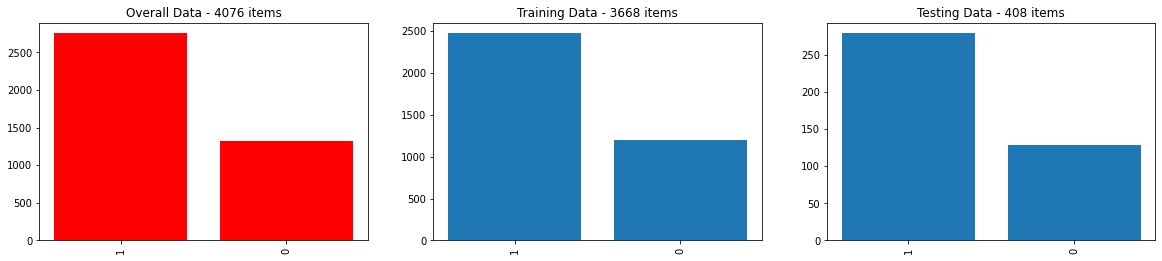

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
y_all = pd.concat([train,test])
value = y_all.value_counts()
axes[0].bar(range(len(value.values)), value.values, color='r')
axes[0].set_xticks(np.arange(len(value.index)))
axes[0].set_xticklabels(value.index, rotation='vertical')
axes[0].set_title('Overall Data - '+ str(len(y_all))+' items')

value = train.value_counts()
axes[1].bar(range(len(value.values)), value.values)
axes[1].set_xticks(np.arange(len(value.index)))
axes[1].set_xticklabels(value.index, rotation='vertical')
axes[1].set_title('Training Data - '+ str(len(y_train))+' items')

value = test.value_counts()
axes[2].bar(range(len(value.values)), value.values)
axes[2].set_xticks(np.arange(len(value.index)))
axes[2].set_xticklabels(value.index, rotation='vertical')
axes[2].set_title('Testing Data - '+ str(len(y_test))+' items')

plt.show()

# axes[0].set_xticks(range(8),return_labels(value.index))
# b = plot_results(true, pred, classes=classes, normalize=None,ax=ax12)
# ax12.set_title('Counts Confusion Matrix')
# axes[0] = y_train.value_counts().plot(kind='bar')
# axes[0] = value.plot.bar(x=return_labels(value.index), y=value.values)


#### Model Evaluation; Confusion Matrix

In [84]:
## Accuracy and Loss on test dataset
model5.evaluate(Xtst_bert_word, test)

13/13 [==============================] - 0s 4ms/step - loss: 1.3152 - accuracy: 0.7721


[1.3151545524597168, 0.7720588445663452]

In [0]:
def glue_combined_results(X, mdl, Xtst, y):
  true_label = list(y)
  pred_label = [np.argmax(lst) for lst in list(mdl.predict(Xtst))]

  comb_results = pd.DataFrame()
  comb_results['Text'] = X['Text']
  comb_results['News headline'] = X['News headline']
  comb_results['true_Label'] = true_label
  comb_results['pred_Label'] = pred_label

  return comb_results

In [0]:
comb_results = glue_combined_results(X_test, model5, Xtst_bert_word, test)

In [91]:
## Sample results

print('Results Data frame; Actual Label.   -', list(comb_results['true_Label'][:10].values))
print('Results Data frame; Predicted Label -', list(comb_results['pred_Label'][:10].values))


Results Data frame; Actual Label.   - [1, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Results Data frame; Predicted Label - [0, 1, 0, 1, 1, 1, 1, 1, 1, 1]


In [92]:
## Unique Predictions

print(np.unique(comb_results['pred_Label']))


[0 1]


In [0]:
classes = [0,1]

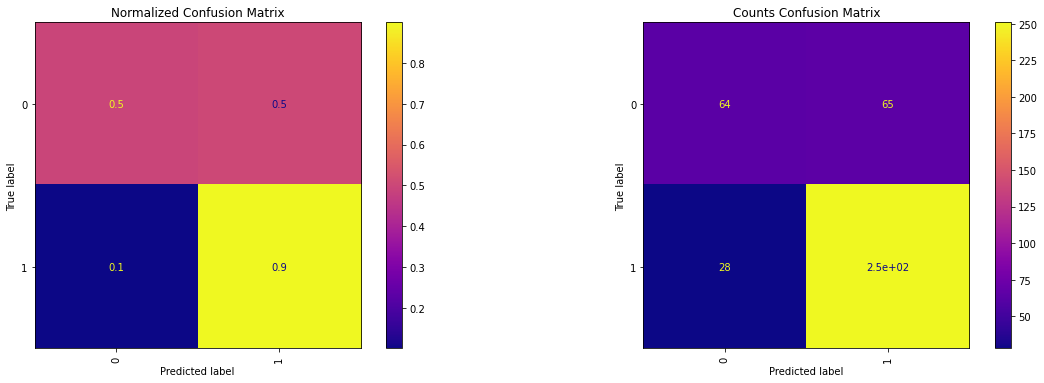

In [94]:
## Confusion Matrix
true = comb_results['true_Label']
pred = comb_results['pred_Label']
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= plot_results(true, pred, classes=classes, normalize='true',ax=ax11)
ax11.set_title('Normalized Confusion Matrix')
b = plot_results(true, pred, classes=classes, normalize=None,ax=ax12)
ax12.set_title('Counts Confusion Matrix')
plt.show()

#### Sample Results

In [96]:
comb_results[comb_results['true_Label'] ==comb_results['pred_Label']].head()

,Text,News headline,true_Label,pred_Label
1,"Terri Schiavo , 39 , underwent the procedure at the Tampa Bay area hospice where she has been living for several years , said her father , Bob Schindler .","The tube was removed Wednesday from Terri Schiavo , 39 , at the Tampa Bay-area hospice where she has lived for several years .",1,1
2,"The study , published Monday in the journal Molecular Brain Research , is likely to also apply to humans , its authors said .","The study , conducted on the brains of developing mice , was being published today in the journal Molecular Brain Research .",0,0
3,It also offers a built-in NAND flash boot loader so that high-density NAND flash memory can be used without having to install an additional support chip .,"The S3C2440 has a built-in NAND flash boot loader , for example , so that high-density NAND flash memory can be installed without an additional support chip .",1,1
4,"Dr Mark McClean , Jonathan 's family doctor , said if the drug had been administered earlier Jonathan would have retained more of his brain functions .","Dr Mark McClean , the family 's GP , said had the drug been administered to Jonathan earlier , he would have retained more of his brain function .",1,1
5,""" There were more people surrounding the clubhouse than the Unabomber 's house up in the hills , "" Baker said .",""" There are more people surrounding the clubhouse than surrounded the Unabomber 's home in the hills .",1,1


In [97]:
comb_results[comb_results['true_Label'] !=comb_results['pred_Label']].head()

,Text,News headline,true_Label,pred_Label
0,The show 's closure affected third-quarter earnings per share by a penny .,The company said this impacted earnings by a penny a share .,1,0
8,"Mr. Kerkorian tried unsuccessfully to take over Chrysler in 1995 , but did win representation on its board .",Kerkorian and Tracinda had also tried to take over Chrysler in 1995 .,0,1
10,"Police suspected that Shaichat , 20 , had been abducted either by Palestinians or by Israeli Arabs .","Nobody claimed responsibility for Schaichat 's death , but police suspect that the 20-year-old soldier was abducted either by Palestinians or Israeli Arabs .",0,1
11,"About two hours later , his body , wrapped in a blanket , was found dumped a few blocks away .","Then his body was dumped a few blocks away , found in a driveway on Argyle Road .",0,1
12,"The Hartford shares rose $ 2.88 , or 6.6 percent , to close Monday at $ 46.50 on the New York Stock Exchange .",Shares of Hartford rose $ 2.88 to $ 46.50 in New York Stock Exchange composite trading .,0,1


#### Actual Vs Prediction distribution

In [0]:
values, counts = np.unique(true, return_counts=True)
values_pred, counts_pred = np.unique(pred, return_counts=True)

In [0]:
pd_true = pd.DataFrame(columns=['label','count'])
pd_pred = pd.DataFrame(columns=['label','count'])

pd_true['label']=values
pd_true['counts']=counts
pd_true['type']='Actual'
pd_pred['label']=values_pred
pd_pred['counts']=counts_pred
pd_pred['type']='Prediction'

pd_results = pd.concat([pd_true, pd_pred])


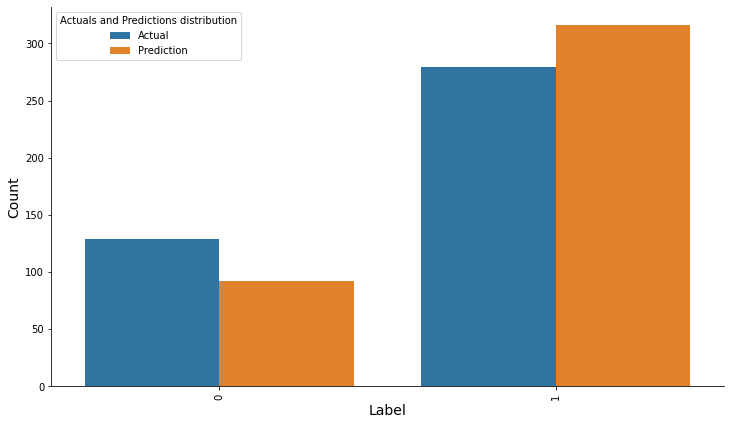

In [100]:
sn.catplot(data=pd_results, x='label', y='counts', hue='type', kind='bar', height=6, aspect=1.7, legend=False)
plt.xticks(rotation=90)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Actuals and Predictions distribution')
plt.show()

#### Another way of presenting confusion matrix

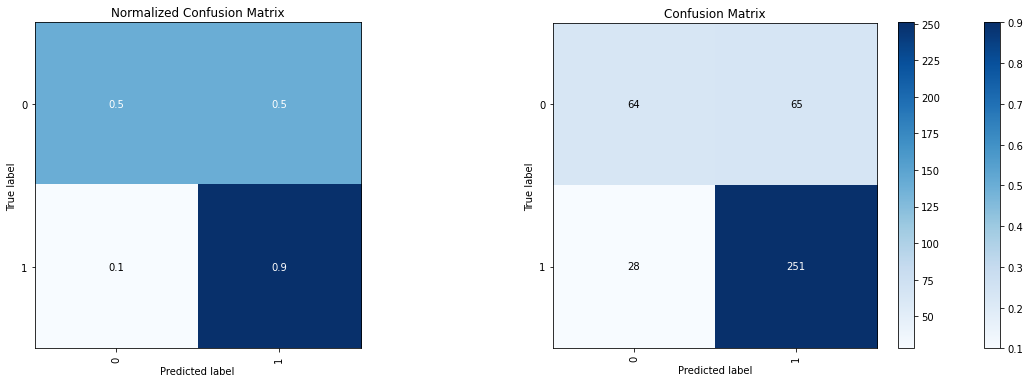

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ax11, ax12 = axes.ravel()
a= skplt.metrics.plot_confusion_matrix(true, pred, normalize=True,x_tick_rotation=90,ax=ax11)
b = skplt.metrics.plot_confusion_matrix(true, pred, normalize=None,x_tick_rotation=90,ax=ax12)
plt.show()